In [5]:
import re
import cv2
import torch
import click
import numpy as np
import albumentations as A
import segmentation_models_pytorch as smp
from pathlib import Path
from PIL import Image

from dataset import RailSem19Dataset

data_dir = './data/rs19_val'

def get_vis_augmentation():
    transform = [
        A.LongestMaxSize(720, cv2.INTER_AREA),
        A.PadIfNeeded(720, 720, cv2.BORDER_CONSTANT),
    ]
    return A.Compose(transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(A.Lambda(image=preprocessing_fn))
    transform.append(A.Lambda(image=to_tensor, mask=to_tensor))
    return A.Compose(transform)

device = 'cuda'
images_dir = str(Path(data_dir).joinpath('jpgs', 'rs19_val'))
masks_dir = str(Path(data_dir).joinpath('uint8', 'rs19_val'))
config_json_path = str(Path(data_dir).joinpath('rs19-config.json'))
preprocessing_fn = smp.encoders.get_preprocessing_fn('resnet101', 'imagenet')

dataset = RailSem19Dataset(
    images_dir, 
    masks_dir, 
    config_json_path,
    0,
    augmentation = get_vis_augmentation(),
    preprocessing = get_preprocessing(preprocessing_fn)
)
best_model = torch.load('./weights/rs19_deeplabv3plus.pth')


/home/kol/kol/rs19_seg/.venv/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:2907: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


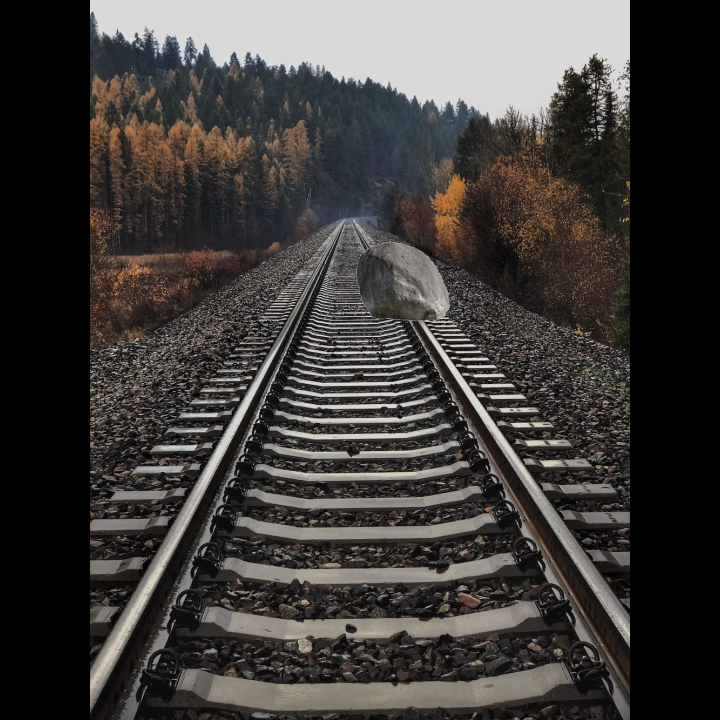

In [6]:
base_class = 'rail-raised'
intersect_class = 'terrain'

image = cv2.imread('./input/sample_with_boulder.png')

orig_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
aug_image = dataset.augmentation(image=orig_image)['image']
pp_image = dataset.preprocessing(image=aug_image)['image']

x_tensor = torch.from_numpy(pp_image).to(device).unsqueeze(0)
pred_mask = best_model.predict(x_tensor)
pred_mask = pred_mask.cpu().numpy().squeeze().transpose(1, 2, 0)
Image.fromarray(aug_image)

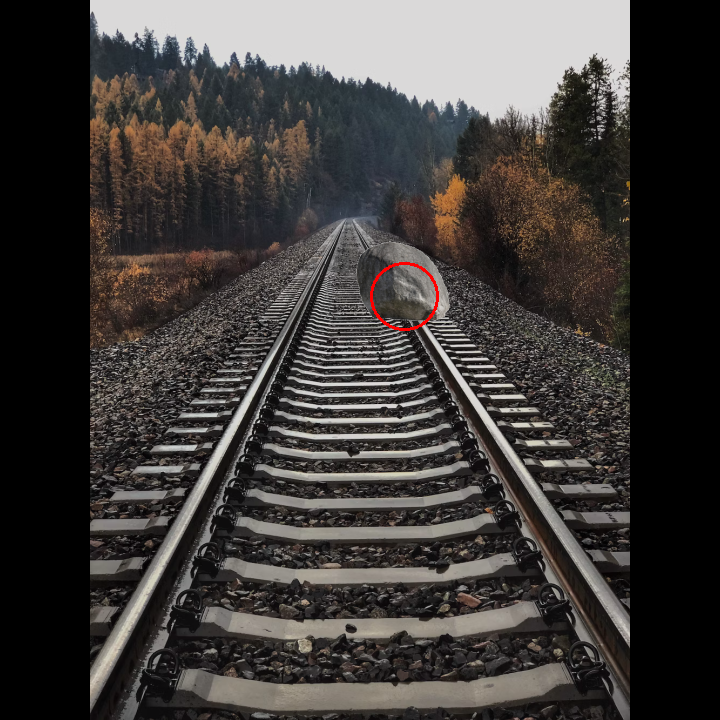

In [14]:
def find_intersection(pred_mask, dataset, output_image, base_class='rail-raised', intersect_class='terrain'):
    threshold = 0.9
    ch = dataset.classes[base_class]['dim']
    base_mask = pred_mask[:,:, ch].squeeze()
    base_mask = np.where(base_mask >= threshold, 255, 0).astype('uint8')

    x0, y0 = 0, 0
    x1, y1 = base_mask.shape[1], int(base_mask.shape[0] * .4)
    base_mask[y0:y1, x0:x1] = 0

    x0, y0 = 0, int(base_mask.shape[0] * .9)
    x1, y1 = base_mask.shape[1], base_mask.shape[0]
    base_mask[y0:y1, x0:x1] = 0

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    base_mask = cv2.morphologyEx(base_mask, cv2.MORPH_OPEN, kernel, iterations=3)

    contours, _ = cv2.findContours(base_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_sorted = sorted(contours, key=cv2.contourArea)

    blank = np.zeros(pred_mask.shape[:2], dtype='uint8')
    h, w = blank.shape[:2]
    rx0, rx1 = blank.shape[1] // 6, blank.shape[1] // 2
    deltas = ((rx0, rx1), (blank.shape[1] // 2, blank.shape[1] // 6))

    for cnt, xd in zip(contours_sorted[-2:], deltas):
        vect = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01)
        vx, vy, x,y = tuple(vect.flatten())
        lefty = int(((xd[0]-x)*vy/vx) + y)
        righty = int(((w-xd[1]-x)*vy/vx) + y)
        cv2.line(blank,(w-xd[1], righty),(xd[0], lefty), 1, 10)

    ch = dataset.classes[intersect_class]['dim']
    intersect_mask = pred_mask[:,:, ch].squeeze()
    blank = np.where(intersect_mask >= threshold, blank+1, blank)
    
    (y,x), r = cv2.minEnclosingCircle(np.argwhere(blank>1))
    cv2.circle(output_image, (int(x), int(y)), int(r), (255,0,0), 2)

    return output_image

Image.fromarray(find_intersection(pred_mask, dataset, aug_image.copy()))

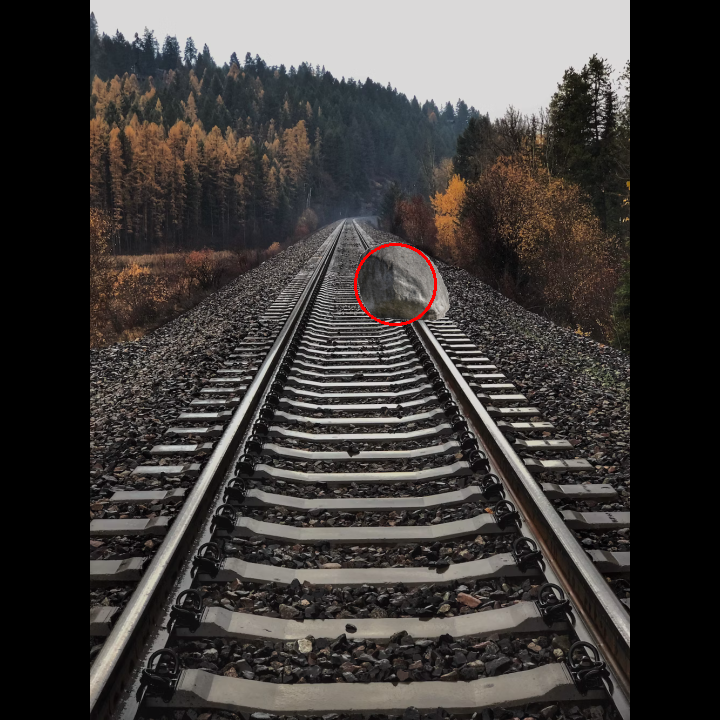

In [29]:
def find_intersection2(pred_mask, dataset, output_image, base_class='rail-raised'):

    upper_threshold = 0.9
    lower_threshold = 0.6

    ch = dataset.classes[base_class]['dim']
    pred = pred_mask[:,:, ch].squeeze()

    vp = ((0, int(pred.shape[0] * .4)), (pred.shape[1], int(pred.shape[0] * .9)))
    vp_mask = np.ones(pred.shape, dtype=bool)
    vp_mask[vp[0][1]:vp[1][1], vp[0][0]:vp[1][0]] = False

    base_mask = np.where(pred >= upper_threshold, 255, 0).astype('uint8')
    base_mask[ vp_mask ] = 0

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    base_mask = cv2.morphologyEx(base_mask, cv2.MORPH_OPEN, kernel, iterations=3)

    contours, _ = cv2.findContours(base_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_sorted = sorted(contours, key=cv2.contourArea)

    obstacle_mask = np.zeros(output_image.shape[:2], bool)
    for cnt in contours_sorted[-2:]:
        vect = cv2.fitLine(cnt, cv2.DIST_L2, 0, 0.01, 0.01).flatten()
        intercept = np.rint(vect[-2:]).astype('int')
        slope = vect[1] / vect[0]

        sy = vp[1][1]
        sx = intercept[0] + int( (sy - intercept[1]) / slope)
        fy = int(output_image.shape[0] * 0.32)
        fx = intercept[0] + int( (fy - intercept[1]) / slope)

        # cv2.circle(output_image, (sx, sy), 5, (0,0,255), -1)
        # cv2.circle(output_image, (fx, fy), 5, (0,0,255), -1)
        # cv2.line(output_image, (sx,sy), (fx,fy), (0,0,255), 2)

        dy = np.arange(fy, sy, 1, dtype='int')
        dx = intercept[0] + ((dy - intercept[1]) // slope).astype('int')

        obstacle_mask[dy,dx] = np.where(pred[dy,dx] <= lower_threshold, True, False)

    (y,x), r = cv2.minEnclosingCircle(np.argwhere(obstacle_mask))
    cv2.circle(output_image, (int(x), int(y)), int(r), (255,0,0), 2)
    return output_image

Image.fromarray(find_intersection2(pred_mask, dataset, aug_image.copy()))

In [33]:
import timeit

p1 = timeit.repeat(lambda : find_intersection(pred_mask, dataset, aug_image.copy()), repeat=5, number=10000)
p2 = timeit.repeat(lambda : find_intersection2(pred_mask, dataset, aug_image.copy()), repeat=5, number=10000)
min(p1), min(p2)

(22.354368814000054, 19.269163410000147)